# Credit Card Fraud Detection

#### 1) Problem statement

The goal of this project is to develop a machine learning model to detect fraudulent credit card transactions. It aims to reduce financial losses by accurately identifying fraud while minimizing false alarms. The solution will handle challenges like class imbalance and feature selection to improve fraud detection and enhance security.

#### 2) Data Set Information

Source: https://www.kaggle.com/datasets/kartik2112/fraud-detection/data

The dataset consists of credit card transaction records with various features that help detect fraudulent activities. Below is a summary of the key attributes and their relevance in fraud detection.

**Key Features:**

   **Transaction Details:** \
   `trans_date_trans_time` → Date & time of the transaction (useful for time-based fraud analysis).\
    `amt` → Transaction amount (important for identifying high-value fraudulent transactions).\
    `merchant` → Merchant name (helps detect fraud-prone merchants).\
    `category` → Type of goods/services purchased (some categories may be more vulnerable to fraud).\
    `trans_num` → Unique transaction ID (used for identification, not modeling).\
    `unix_time` → Transaction timestamp (alternative to trans_date_trans_time).
    
   **Cardholder Information:** \
   `cc_num` → Credit card number (sensitive; typically not used in modeling).\
    `first`, `last` → Name of the cardholder (personal data, not essential for fraud detection).\
    `gender` → Cardholder’s gender (may or may not influence fraud patterns).\
    `dob` → Date of birth (can help detect age-related fraud patterns).

   **Location-Based Features:** \
    `street`, `city`, `state`, `zip` → Address-related details (useful for detecting location inconsistencies).\
    `lat`, `long` → Cardholder’s geographic coordinates (helps in fraud detection based on location).\
    `city_pop` → City population (may provide context for fraud trends).\
    `merch_lat`, `merch_long` → Merchant’s location coordinates (useful for detecting unusual purchase locations).

   **Target Variable:** \
    `is_fraud` → 1 for fraudulent transactions, 0 for legitimate transactions (used for model training).

In [1]:
#Import Required Libraries

import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams
from sklearn.model_selection import train_test_split, RandomizedSearchCV, RepeatedStratifiedKFold, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from imblearn.over_sampling import SMOTE, RandomOverSampler
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression, Perceptron, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report, roc_curve, auc
from datetime import datetime


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Load Dataset
df = pd.read_csv('D:/MBA/Project/Data set/merged_file_2.csv')

### Exploratory Data Analysis

In [4]:
print("Dataset Info:")
df.info()

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1852394 entries, 0 to 1852393
Data columns (total 24 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Unnamed: 0.1           int64  
 1   Unnamed: 0             int64  
 2   trans_date_trans_time  object 
 3   cc_num                 int64  
 4   merchant               object 
 5   category               object 
 6   amt                    float64
 7   first                  object 
 8   last                   object 
 9   gender                 object 
 10  street                 object 
 11  city                   object 
 12  state                  object 
 13  zip                    int64  
 14  lat                    float64
 15  long                   float64
 16  city_pop               int64  
 17  job                    object 
 18  dob                    object 
 19  trans_num              object 
 20  unix_time              int64  
 21  merch_lat              float64
 22  merc

In [5]:
# Check missing values
null_count=df.isnull().sum()
print("Nulls:")
print(null_count)

Nulls:
Unnamed: 0.1             0
Unnamed: 0               0
trans_date_trans_time    0
cc_num                   0
merchant                 0
category                 0
amt                      0
first                    0
last                     0
gender                   0
street                   0
city                     0
state                    0
zip                      0
lat                      0
long                     0
city_pop                 0
job                      0
dob                      0
trans_num                0
unix_time                0
merch_lat                0
merch_long               0
is_fraud                 0
dtype: int64


In [6]:
duplicate_count=df.duplicated(keep=False).sum()
print("Duplicates:")
print(duplicate_count)

Duplicates:
0


In [7]:
# Drop Unnecessary Columns
df.drop(['Unnamed: 0', 'Unnamed: 0.1'], axis=1, inplace=True)

### Correlation matrix

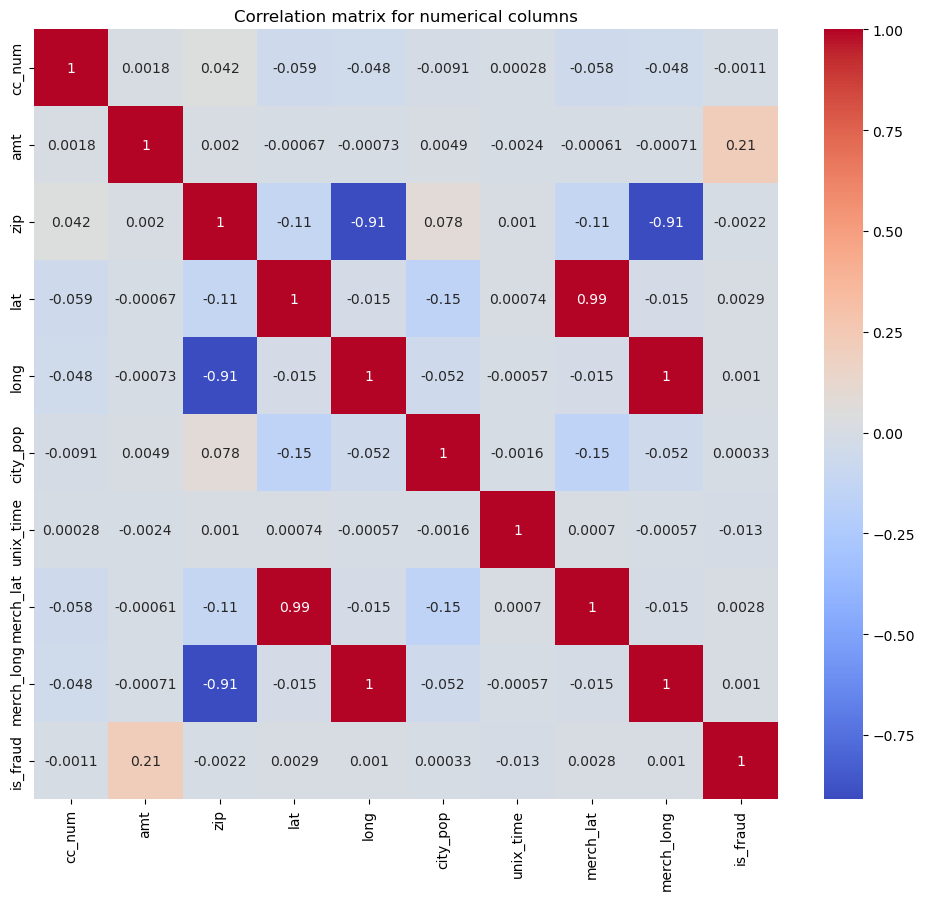

In [8]:
# Select all numeric columns (both int64 and float64)
df_numerical = df.select_dtypes(include=[np.number])

# Plot correlation matrix for numerical columns
plt.figure(figsize=(12,10))
sns.heatmap(df_numerical.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation matrix for numerical columns")
plt.show()

####  Correlation Observations
- `long`, `merch_long`, and `zip` exhibit high correlation, which is expected due to their geographic nature.  
- To reduce multicollinearity and enhance model performance, some of these features may be removed during EDA and preprocessing.

Class Distribution (%):
is_fraud
0    99.478999
1     0.521001
Name: proportion, dtype: float64


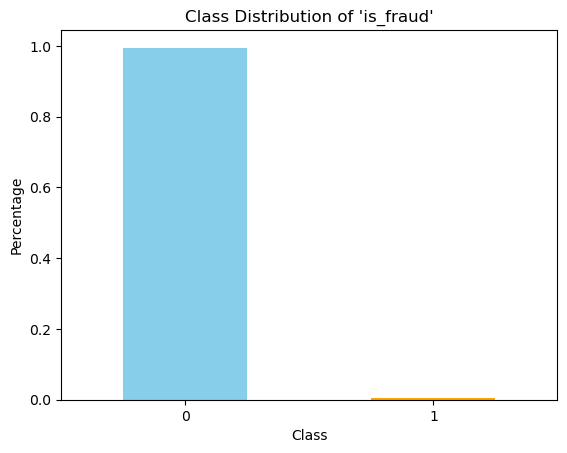

In [9]:
# Check class distribution
class_distribution = df['is_fraud'].value_counts(normalize=True)

# Display the distribution as percentages
print("Class Distribution (%):")
print(class_distribution * 100)

class_distribution.plot(kind='bar', color=['skyblue', 'orange'])
plt.title("Class Distribution of 'is_fraud'")
plt.xlabel("Class")
plt.ylabel("Percentage")
plt.xticks(rotation=0)
plt.show()

#### Feature Engineering

In [10]:
# Extract DateTime Features
df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])
df['transaction_hour'] = df['trans_date_trans_time'].dt.hour
df['day_of_week'] = df['trans_date_trans_time'].dt.day_name()
df['transaction_month'] = df['trans_date_trans_time'].dt.month
df['is_weekend'] = df['trans_date_trans_time'].dt.weekday.isin([5, 6]).astype(int)

In [11]:
# Categorize time of transaction
def categorize_part_of_day(hour):
    if 5 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 17:
        return 'Afternoon'
    elif 17 <= hour < 21:
        return 'Evening'
    else:
        return 'Night'
    
df['part_of_day'] = df['transaction_hour'].apply(categorize_part_of_day)

In [12]:
# Convert 'dob' to age
df['dob'] = pd.to_datetime(df['dob'], errors='coerce')
reference_date = datetime(2020, 12, 31)
df['age'] = (reference_date - df['dob']).dt.days // 365

# Categorize age groups
def categorize_age_group(age):
    if age <= 12:
        return 'Child'
    elif 13 <= age <= 17:
        return 'Teenager'
    elif 18 <= age <= 25:
        return 'Young Adult'
    elif 26 <= age <= 40:
        return 'Adult'
    elif 41 <= age <= 60:
        return 'Middle-Aged'
    elif 61 <= age <= 80:
        return 'Senior'
    else:
        return 'Elderly'

df['age_group'] = df['age'].apply(categorize_age_group)

In [13]:
# Calculate Distance Between Cardholder and Merchant
def calculate_distance(lat1, lon1, lat2, lon2):
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return 6371 * c  # Radius of Earth in km

df['distance'] = calculate_distance(df['lat'], df['long'], df['merch_lat'], df['merch_long'])

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1852394 entries, 0 to 1852393
Data columns (total 30 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   trans_date_trans_time  datetime64[ns]
 1   cc_num                 int64         
 2   merchant               object        
 3   category               object        
 4   amt                    float64       
 5   first                  object        
 6   last                   object        
 7   gender                 object        
 8   street                 object        
 9   city                   object        
 10  state                  object        
 11  zip                    int64         
 12  lat                    float64       
 13  long                   float64       
 14  city_pop               int64         
 15  job                    object        
 16  dob                    datetime64[ns]
 17  trans_num              object        
 18  unix_time             

In [15]:
columns_to_remove = ['trans_date_trans_time', 'cc_num','first', 'last', 'gender', 'street', 'city', 'state', 'zip','lat', 'long',  'job', 'dob', 'trans_num', 'unix_time', 'merch_lat', 'merch_long']

# Drop the specified columns from df_eda
df.drop(columns=columns_to_remove, inplace=True)

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1852394 entries, 0 to 1852393
Data columns (total 13 columns):
 #   Column             Dtype  
---  ------             -----  
 0   merchant           object 
 1   category           object 
 2   amt                float64
 3   city_pop           int64  
 4   is_fraud           int64  
 5   transaction_hour   int32  
 6   day_of_week        object 
 7   transaction_month  int32  
 8   is_weekend         int32  
 9   part_of_day        object 
 10  age                int64  
 11  age_group          object 
 12  distance           float64
dtypes: float64(2), int32(3), int64(3), object(5)
memory usage: 162.5+ MB


In [17]:
# Bifurcating data into categorical and numerical features
category_features = ['merchant', 'category', 'transaction_month', 'day_of_week', 'part_of_day', 'is_weekend', 'age_group']
numerical_features = ['amt', 'city_pop', 'age', 'distance']
features = category_features + numerical_features
target = ['is_fraud']

In [18]:
import pandas as pd

def outliers_analysis(df, column_names):
    records = []
    for col in column_names:
        Q1 = df[col].quantile(0.25)  # 25th percentile
        Q3 = df[col].quantile(0.75)  # 75th percentile
        IQR = Q3 - Q1  # Interquartile range
        min_whisker = Q1 - 1.5 * IQR  # Lower boundary
        max_whisker = Q3 + 1.5 * IQR  # Upper boundary
        
        # Compute the percentage of outliers
        outlier_percentage = ((df[col] < min_whisker) | (df[col] > max_whisker)).mean() * 100

        # Assign remark based on outlier percentage
        if outlier_percentage == 0.0:
            remark = 'No Outliers present.'
        elif outlier_percentage <= 5.0:
            remark = 'No need to handle outliers'
        else:
            remark = 'Need to handle outliers'
        
        records.append({
            'Feature': col, 
            'Min_Whisker': min_whisker, 
            'Max_Whisker': max_whisker, 
            'Outlier_Percentage': outlier_percentage, 
            'Remark': remark
        })

    return pd.DataFrame(records)


In [19]:
df_outlier = outliers_analysis(df, numerical_features)
print(df_outlier)

    Feature   Min_Whisker   Max_Whisker  Outlier_Percentage  \
0       amt   -100.550000    193.290000            5.131414   
1  city_pop -28639.500000  49708.500000           18.688843   
2       age     -4.500000     95.500000            0.039678   
3  distance     -9.463983    163.293538            0.000000   

                       Remark  
0     Need to handle outliers  
1     Need to handle outliers  
2  No need to handle outliers  
3        No Outliers present.  


In [20]:
# Outlier Handling - Capping for 'age' and 'distance'
def cap_outliers(df, column):
    lower_bound = df[column].quantile(0.01)
    upper_bound = df[column].quantile(0.99)
    df[column] = np.clip(df[column], lower_bound, upper_bound)
    return df

df = cap_outliers(df, 'amt')
df = cap_outliers(df, 'city_pop')

In [21]:
# Data Preprocessing from File 2
categorical_cols = category_features
numerical_cols = numerical_features

In [22]:
# Label Encoding
le = LabelEncoder()
for col in categorical_cols:
    df[col] = le.fit_transform(df[col])

In [23]:
# Define Features and Target
X = df[features]
y = df['is_fraud']

In [24]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [25]:
# Handle Class Imbalance using SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

In [26]:
print(y_train_smote.value_counts())

is_fraud
0    1382038
1    1382038
Name: count, dtype: int64


In [27]:
def Classification_models_evaluation (models,X_train=X_train_smote,y_train=y_train_smote,X_test=X_test,y_test=y_test) :
    before = pd.DataFrame(columns=['Model_Name','Training_Score','Testing_Score','Accuracy_Score','Precision_Score','Recall_Score','F1_Score','Confusion_Matrix-[[TN,FP],[FN,TP]]'])
    for i in range (len(models)):
        name = models[i]
        print(name)
        model = models[i]
        model.fit(X_train,y_train)
        y_predict = model.predict(X_test)
        train_score = round(model.score(X_train,y_train)* 100, 2)
        test_score = round(model.score(X_test,y_test) * 100,2)
        accuracy = round(accuracy_score(y_test,y_predict) * 100,2)
        precision = round(precision_score(y_test, y_predict,average='micro') * 100,2)
        recall = round(recall_score(y_test, y_predict,average='micro') * 100,2)
        f1score = round(f1_score(y_test, y_predict,average='micro') * 100,2)
        con_matrix=confusion_matrix(y_test,y_predict)
        new=pd.Series([name,train_score,test_score,accuracy,precision,recall,f1score,con_matrix],index=['Model_Name','Training_Score','Testing_Score','Accuracy_Score','Precision_Score','Recall_Score','F1_Score','Confusion_Matrix-[[TN,FP],[FN,TP]]'])
        new= pd.DataFrame(new).transpose()
        before=pd.concat([before,new],ignore_index=True)  
    return before

In [28]:
# basic model after handling outlier & skewness.
basic_models_list = [LogisticRegression(),XGBClassifier(),GradientBoostingClassifier(),RandomForestClassifier(),AdaBoostClassifier(),BaggingClassifier(),
                     GaussianNB(),DecisionTreeClassifier(),MLPClassifier()]

# prepare tabular model comparison dataframe
basic_models = Classification_models_evaluation(basic_models_list)
# print(before.head(2))
# convert dataframe "model name" into string and then split string to retrive model name only.
basic_models['Model_Name'] = [str(i) for i in basic_models['Model_Name']]
basic_models['Model_Name']=basic_models['Model_Name'].str.split('(').str[0]
basic_models

LogisticRegression()
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)
GradientBoostingClassifier()
RandomForestClassifier()
AdaBoostClassifier()
BaggingClassifier()
GaussianNB()
DecisionTreeClassifier()
MLPClassifier()


,Model_Name,Training_Score,Testing_Score,Accuracy_Score,Precision_Score,Recall_Score,F1_Score,"Confusion_Matrix-[[TN,FP],[FN,TP]]"
0,LogisticRegression,84.44,91.57,91.57,91.57,91.57,91.57,"[[422259, 38446], [595, 1799]]"
1,XGBClassifier,98.24,98.49,98.49,98.49,98.49,98.49,"[[453998, 6707], [274, 2120]]"
2,GradientBoostingClassifier,94.68,96.26,96.26,96.26,96.26,96.26,"[[443655, 17050], [251, 2143]]"
3,RandomForestClassifier,100.0,99.49,99.49,99.49,99.49,99.49,"[[458932, 1773], [572, 1822]]"
4,AdaBoostClassifier,93.34,94.34,94.34,94.34,94.34,94.34,"[[434811, 25894], [334, 2060]]"
5,BaggingClassifier,99.98,99.32,99.32,99.32,99.32,99.32,"[[458156, 2549], [602, 1792]]"
6,GaussianNB,85.97,94.86,94.86,94.86,94.86,94.86,"[[437487, 23218], [603, 1791]]"
7,DecisionTreeClassifier,100.0,98.85,98.85,98.85,98.85,98.85,"[[456084, 4621], [690, 1704]]"
8,MLPClassifier,92.78,95.58,95.58,95.58,95.58,95.58,"[[440630, 20075], [412, 1982]]"


In [29]:
basic_models[basic_models['F1_Score']>=85].sort_values('F1_Score',ascending=False).head(5)

,Model_Name,Training_Score,Testing_Score,Accuracy_Score,Precision_Score,Recall_Score,F1_Score,"Confusion_Matrix-[[TN,FP],[FN,TP]]"
3,RandomForestClassifier,100.0,99.49,99.49,99.49,99.49,99.49,"[[458932, 1773], [572, 1822]]"
5,BaggingClassifier,99.98,99.32,99.32,99.32,99.32,99.32,"[[458156, 2549], [602, 1792]]"
7,DecisionTreeClassifier,100.0,98.85,98.85,98.85,98.85,98.85,"[[456084, 4621], [690, 1704]]"
1,XGBClassifier,98.24,98.49,98.49,98.49,98.49,98.49,"[[453998, 6707], [274, 2120]]"
2,GradientBoostingClassifier,94.68,96.26,96.26,96.26,96.26,96.26,"[[443655, 17050], [251, 2143]]"


In [30]:
model=RandomForestClassifier()
model.fit(X_train,y_train)
y_predict = model.predict(X_test)
train_score = round(model.score(X_train,y_train)* 100, 2)
test_score = round(model.score(X_test,y_test) * 100,2)
accuracy = round(accuracy_score(y_test,y_predict) * 100,2)
precision = round(precision_score(y_test, y_predict,average='micro') * 100,2)
recall = round(recall_score(y_test, y_predict,average='micro') * 100,2)
f1score = round(f1_score(y_test, y_predict,average='micro') * 100,2)
con_matrix=confusion_matrix(y_test,y_predict)
print(train_score, test_score, accuracy,precision, recall,f1score,con_matrix)

100.0 99.76 99.76 99.76 99.76 99.76 [[460419    286]
 [   835   1559]]


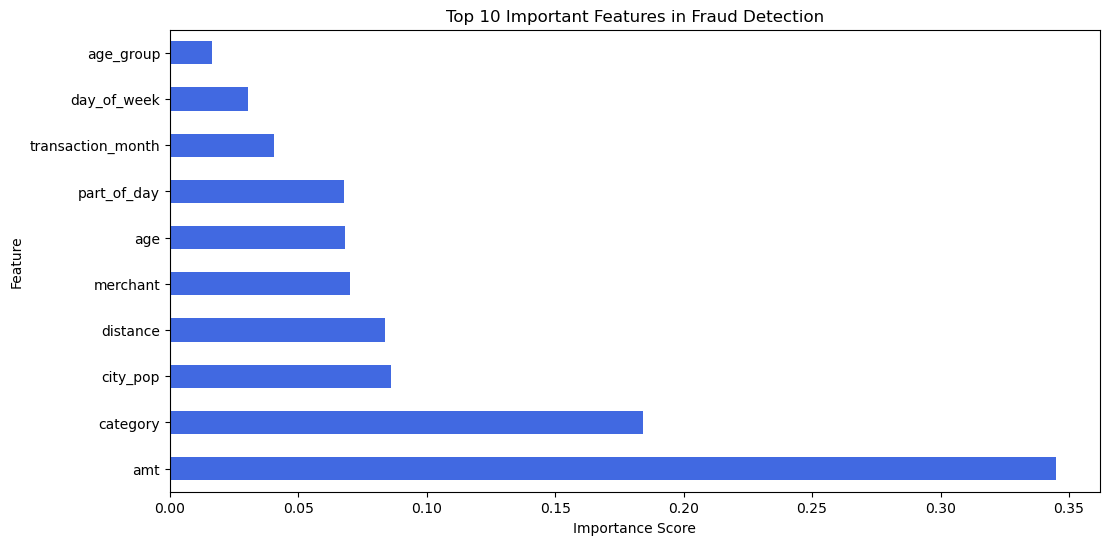

In [31]:
# Get feature importance scores from the trained RandomForest model
feature_importances = pd.Series(model.feature_importances_, index=X.columns)

# Sort and plot the top 10 important features
plt.figure(figsize=(12,6))
feature_importances.nlargest(10).plot(kind='barh', color='royalblue')
plt.title("Top 10 Important Features in Fraud Detection")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.show()


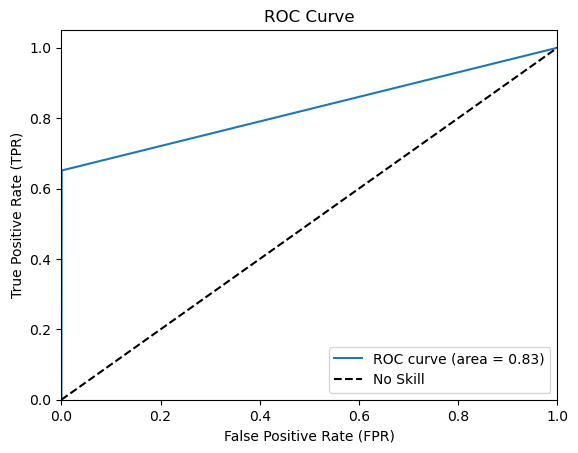

AUC: 0.8252952870159395


In [32]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_test, y_predict)
roc_auc = auc(fpr, tpr)


plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--', label='No Skill')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

# Print AUC value
print("AUC:", roc_auc)

In [33]:
feature_names = X_train_smote.columns
feature_names

Index(['merchant', 'category', 'transaction_month', 'day_of_week',
       'part_of_day', 'is_weekend', 'age_group', 'amt', 'city_pop', 'age',
       'distance'],
      dtype='object')

In [34]:
importances = model.feature_importances_

gini_importance = 2 * np.abs(importances - 0.5)

for i, feature_name in enumerate(feature_names):
  print(f"Feature {feature_name} (Gini Importance): {gini_importance[i]:.4f}")

Feature merchant (Gini Importance): 0.8595
Feature category (Gini Importance): 0.6314
Feature transaction_month (Gini Importance): 0.9190
Feature day_of_week (Gini Importance): 0.9392
Feature part_of_day (Gini Importance): 0.8645
Feature is_weekend (Gini Importance): 0.9843
Feature age_group (Gini Importance): 0.9671
Feature amt (Gini Importance): 0.3104
Feature city_pop (Gini Importance): 0.8278
Feature age (Gini Importance): 0.8640
Feature distance (Gini Importance): 0.8328
